# Directed Search
After having run 'policy_search.py' for the five scenarios that we selected based on PRIM, we are left with four different csv files for all five scenarios. These csv files contain sets of optimised policies for the respective scenario and seed (we ran four seeds). This notebook will further investigate these policies and aim to filter them down to a top 50 in terms of performance and diversity.

In [28]:
# Import all modules
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Constraint,
)
from ema_workbench.em_framework.optimization import EpsilonProgress, epsilon_nondominated
from ema_workbench.util import ema_logging

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger

# Note that we are using the custom problem formulation without RfR outcomes here, as we are not interested in RfR and issues arise when using the custom problem formulation with RfR outcomes
from custom_problem_formulation_no_RfR import get_model_for_problem_formulation

import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd


As briefly noted above, we won't use 'custom_problem_formulation.py' here, but use 'custom_problem_formulation_no_RfR' instead. This was done because the way we intially set up RfR costs to be measured was erroneous. We wanted to measure them per dike ring, which is impossible given that that's not how they're being calculated. As a result of this the RfR costs would always be zero, regardless of the scenario or policy. Unfortunately we only found out later (the convergence couldn't be calculated due to these RfR costs always being zero), therefore they had to be deleted from the optimisation results. However, this lead to another issue as the RfR costs were expected as outcomes due to them being defined as such in 'custom_problem_formulation.py'. Due to time constraints we didn't want to run all analyses from the start again (with a modified problem formulation), so our solution was to simply delete the RfR cost variables from the optimisation results, and create a modified 'custom_problem_formulation_no_RfR.py' without the RfR costs outcomes, so that we could load that formulation in this notebook and we wouldn't get the error that RfR Costs were expected as outcomes when calculating the convergence.

In [29]:
# Set up logging and the problem
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation()
problem = to_problem(model, searchover="levers")

In [241]:
# Load the selected scenarios
scenarios_df = pd.read_csv('results/selected_scenarios.csv')
scenarios_df.rename(columns={'Unnamed: 0': 'scenario_id'}, inplace=True)
scenarios_df = scenarios_df.set_index('scenario_id')
scenarios_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
scenario_id,,,,,,,,,,,,,,,,,,,
17872,35,186.293269,10.0,0.343812,77.401051,1.0,0.658147,264.897385,10.0,0.541336,223.484894,1.0,0.539570,98.099726,1.0,0.387690,1.5,1.5,4.5
11066,123,108.477854,10.0,0.203210,283.478318,1.5,0.432853,222.229473,1.5,0.140830,40.489532,10.0,0.969984,315.559704,10.0,0.745238,3.5,3.5,1.5
18563,104,313.352612,1.0,0.335359,83.602832,1.5,0.048482,331.280944,10.0,0.942171,116.239569,1.0,0.444281,207.833347,10.0,0.958399,1.5,4.5,4.5
32143,126,340.835544,1.0,0.049016,113.855005,10.0,0.757939,332.888162,1.0,0.130000,131.107110,1.5,0.075126,81.769375,1.0,0.532889,3.5,1.5,4.5
5666,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,340.402481,1.0,0.086792,75.494126,1.5,0.826855,1.5,1.5,1.5


In [242]:
# To prepare for loading the results from the optimisation we setup dictionaries to store them in
scenario_ids = scenarios_df.index.to_list()
archive_dict = {}
results_dict = {}
convergence_dict = {}
amount_of_seeds = 4

# Load the results from the optimisation for each scenario
for scenario in scenario_ids:
    archive_list = []
    results_list = []
    convergence_list = []
    for i in range(amount_of_seeds): # Load the results for each seed

        # Load the archive files which will be used for convergence testing
        archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
        for key, df in archives.items():
            if 'Unnamed: 0' in df.columns:
                del df['Unnamed: 0']
            # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns for the reason explained above
            df.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        archive_list.append(archives)

        # Load the results
        result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
        # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns for the reason explained above
        result.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        results_list.append(result)

        # Load the convergence metrics
        convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
        convergence_list.append(convergence)

    archive_dict[scenario] = archive_list
    results_dict[scenario] = results_list
    convergence_dict[scenario] = convergence_list

Given that each seed results in slightly different optimal policies, there's a chance that some policies from one seed are dominated by those in another seed. These policies can be deleted to further filter down our policy set. However, before we do that we quickly examine how many unique policies each scenario has by dropping duplicate policies.

In [30]:
# Checking how many unique policies there were at first to get an idea of how many policies were removed
for scenario in scenario_ids:
    # Concatenate DataFrames for all seeds
    df_all_seeds = pd.concat(results_dict[scenario])

    # Drop duplicate rows
    df_unique_policies = df_all_seeds.drop_duplicates()

    # Print the number of unique policies
    print(f"Scenario {scenario} has {df_unique_policies.shape[0]} unique policies")

Scenario 17872 has 32 unique policies
Scenario 11066 has 160 unique policies
Scenario 18563 has 460 unique policies
Scenario 32143 has 68 unique policies
Scenario 5666 has 1210 unique policies


In [31]:
policy_dict = {} # Setup dictionary to store the non-dominated policies
epsilon = [100, 100, 0.01, 100, 100, 100, 0.01, 100] # Set the epsilon values, these are based on the scale and importance of the outcomes
for i in range(len(scenario_ids)):
    df = epsilon_nondominated(results_dict[scenario_ids[i]], epsilon, problem) # This function doesn't work properly anymore, we had to change lines 893 and 895 in optimization.py in the em_framework
    policy_dict[scenario_ids[i]] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario_ids[i]} has {n_policies} non-dominated policies")


Scenario 17872 has 8 non-dominated policies
Scenario 11066 has 40 non-dominated policies
Scenario 18563 has 115 non-dominated policies
Scenario 32143 has 20 non-dominated policies
Scenario 5666 has 320 non-dominated policies


After removing the dominated policies, we are left with approximately 500 policies. To confirm that these truly are optimal policies, we now further investigate if the algorithm used to find these policies actually converged for each scenario and seed, indicating that it has found the optimal policies.

In [20]:
# Calculate convergence metrics
convergence_metrics = {}
for scenario in scenario_ids:
    pols = policy_dict[scenario]
    hv = HypervolumeMetric(pols, problem)
    gd = GenerationalDistanceMetric(pols, problem, d=1)
    ei = EpsilonIndicatorMetric(pols, problem)
    ig = InvertedGenerationalDistanceMetric(pols, problem, d=1)
    sm = SpacingMetric(problem)

    convergence_metrics[scenario] = []

    for archive in archive_dict[scenario]:
        metrics = []
        for nfe, a in archive.items():
            scores = {
                "generational_distance": gd.calculate(a),
                "hypervolume": hv.calculate(a),
                "epsilon_indicator": ei.calculate(a),
                "inverted_gd": ig.calculate(a),
                "spacing": sm.calculate(a),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        convergence_metrics[scenario].append(metrics)

In [21]:
# Quickly saving the convergence metrics to a pickle file
import pickle
with open('results/convergence_metrics.pkl', 'wb') as f:
    pickle.dump(convergence_metrics, f)

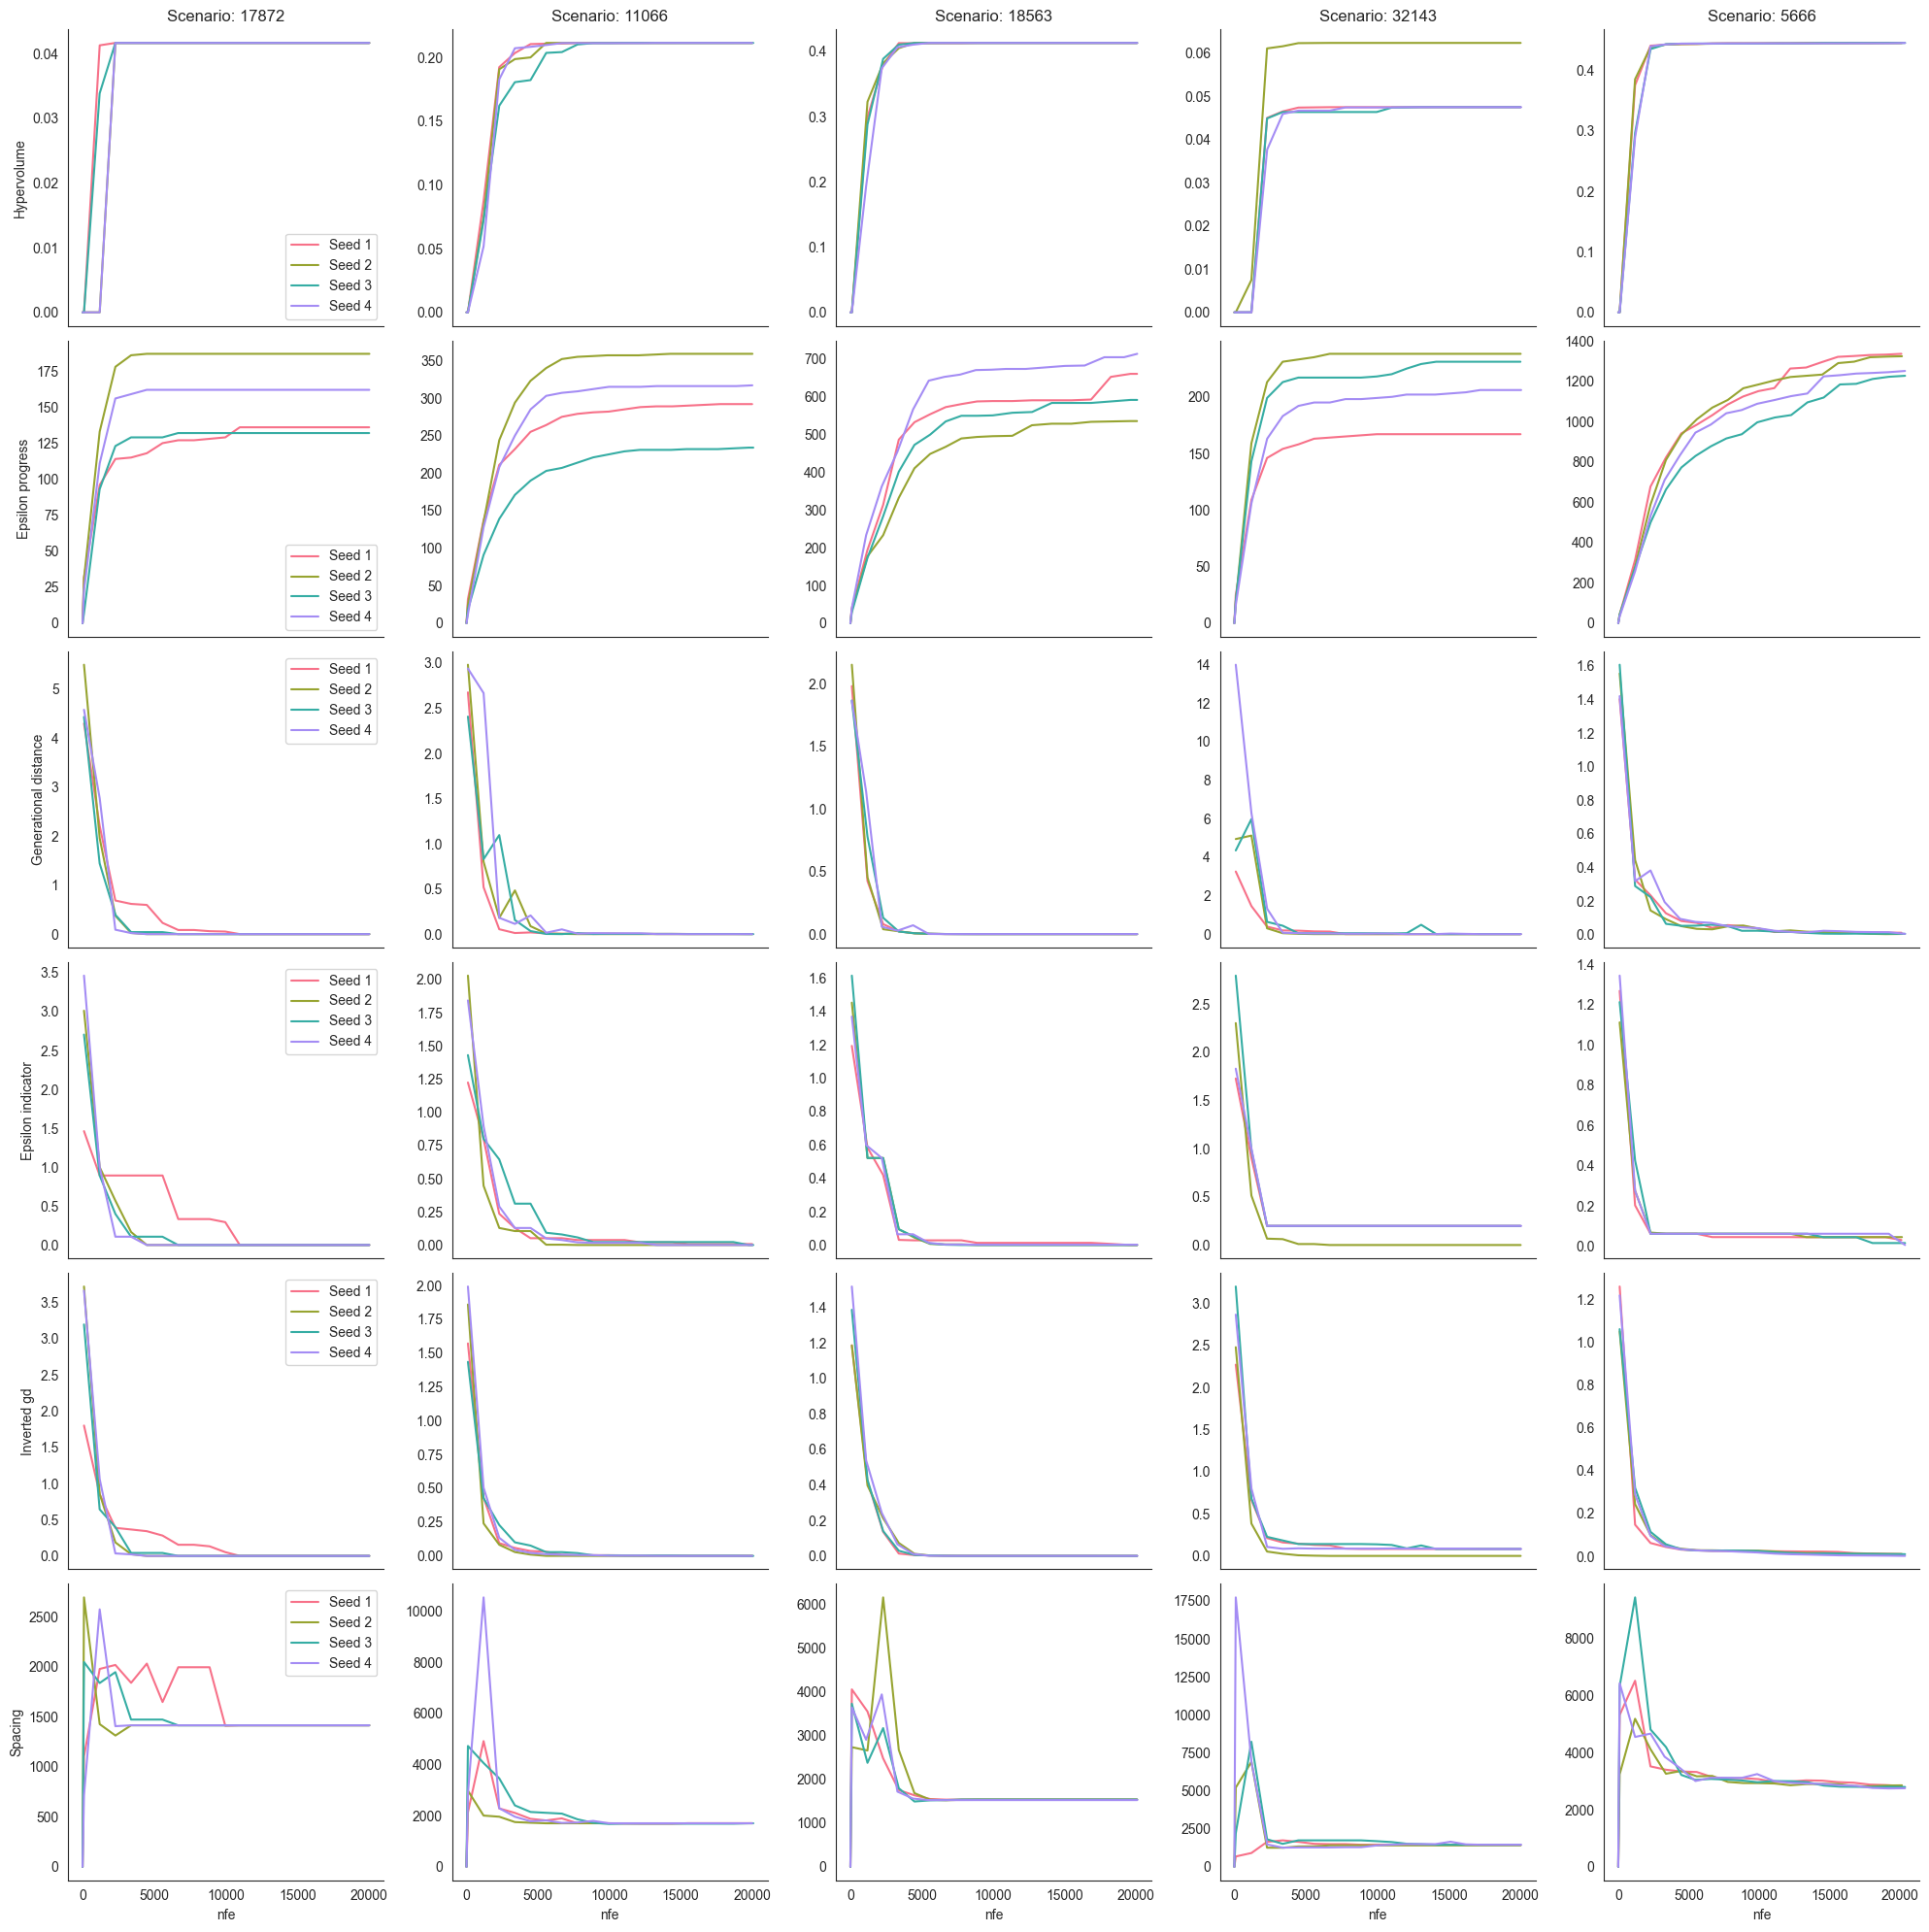

In [26]:
# Load the convergence metrics from the pickle file
with open('results/convergence_metrics.pkl', 'rb') as f:
    convergence_metrics = pickle.load(f)

# Set the style for seaborn
sns.set_style("white")

# Define the number of scenarios and metrics
num_scenarios = len(convergence_metrics)
num_metrics = 6  # hypervolume, epsilon progress, generational distance, epsilon indicator, inverted generational distance, spacing

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_metrics, ncols=num_scenarios, figsize=(20, 20), sharex='col')

# List of metric names for convergence metrics and a placeholder for epsilon progress
metric_names = ['hypervolume', 'epsilon_progress', 'generational_distance', 'epsilon_indicator', 'inverted_gd', 'spacing']

# Iterate over each scenario in the convergence metrics
for col_idx, (scenario, metrics_list) in enumerate(convergence_metrics.items()):
    # Create a color palette with enough colors for each seed in the scenario
    palette = sns.color_palette("husl", len(metrics_list))

    for row_idx, metric_name in enumerate(metric_names):
        ax = axes[row_idx, col_idx]
        if metric_name == 'epsilon_progress':
            for seed_idx, convergence in enumerate(convergence_dict[scenario]):
                color = palette[seed_idx]  # Get a color from the palette for this seed
                ax.plot(convergence['nfe'], convergence[metric_name], color=color, label=f'Seed {seed_idx+1}' if col_idx == 0 else "")
        else:
            for seed_idx, metrics in enumerate(metrics_list):
                color = palette[seed_idx]  # Get a color from the palette for this seed
                ax.plot(metrics['nfe'], metrics[metric_name], color=color, label=f'Seed {seed_idx+1}' if col_idx == 0 else "")
        
        # Set y-axis label only on the first column
        if col_idx == 0:
            ax.set_ylabel(metric_name.replace('_', ' ').capitalize())

        # Set title for each scenario in the first row
        if row_idx == 0:
            ax.set_title(f'Scenario: {scenario}')

# Set the xlabel for the last row of subplots
for ax in axes[-1, :]:
    ax.set_xlabel("nfe")

# Add legends to the first subplot in each row
for ax in axes[:, 0]:
    ax.legend()

# Despine the figure
sns.despine(fig)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('results/convergence_metrics.png')

# Show the plot
plt.show()

QUICKLY DISCUSS RESULTS


Now that we can relatively confidently say that we have found a good set of potential policies, we have to filter down the set even further to be able to provide our stakeholder with a sound advice. One option of further limiting our set of policies is by imposing additional constraints. As mentioned we value 'A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage' and 'A.2_Expected Number of Deaths' equally. That's why we priorly constructed the 'composite_ooi' score for the base case scenarios. We can construct this composite_ooi score again for the remaining policies. Next, we can compare the composite_ooi score for the base case and for the implemented policies for each specific scenario. We can now constrain our resulting policy set by only further considering the policies that provide an improvement (thus lower composite_ooi score) over the base case (i.e. the no policy option) of at least PERCENTAGE  

In [248]:
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

def normalize_and_compute_composite_ooi(df):
    """
    Normalize the selected columns of the input dataframe using MinMaxScaler and compute the composite OOI.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe containing the columns to be normalized.
    
    Returns:
    pandas.DataFrame: The input dataframe with an additional column 'composite_ooi' representing the composite OOI.
    """
    scaler = MinMaxScaler()
    normalized_ooi = scaler.fit_transform(df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                              'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
    composite_ooi = normalized_ooi.sum(axis=1)
    df['composite_ooi'] = composite_ooi 
    return df


[17872, 11066, 18563, 32143, 5666]

In [249]:
df_17872 = normalize_and_compute_composite_ooi(policy_dict[17872])
df_11066 = normalize_and_compute_composite_ooi(policy_dict[11066])
df_18563 = normalize_and_compute_composite_ooi(policy_dict[18563])
df_32143 = normalize_and_compute_composite_ooi(policy_dict[32143])
df_5666 = normalize_and_compute_composite_ooi(policy_dict[5666])


In [250]:
df_base = pd.read_csv('results/base_case_results.csv',index_col=0)
df_base = df_base.loc[[17872, 11066, 18563, 32143, 5666]]

In [251]:
df_base_composite_ooi = normalize_and_compute_composite_ooi(df_base)

In [252]:
df_base_composite_ooi

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.0_ID flood wave shape,A.1_Bmax,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
17872,0,0,1.559375,2.626352e+09,0,0,0.000000,0.000000e+00,35,186.293269,...,0,0,0,0,0,0,17872,No Policy,dikesnet,0.953916
11066,0,0,1.566391,2.346184e+09,0,0,0.021393,2.307206e+07,123,108.477854,...,0,0,0,0,0,0,11066,No Policy,dikesnet,1.289737
18563,0,0,1.556445,2.102426e+09,0,0,0.610686,6.605148e+08,104,313.352612,...,0,0,0,0,0,0,18563,No Policy,dikesnet,1.802066
32143,0,0,1.553632,2.215112e+09,0,0,0.000000,0.000000e+00,126,340.835544,...,0,0,0,0,0,0,32143,No Policy,dikesnet,0.108358
5666,0,0,1.556445,3.142364e+09,0,0,0.650128,1.028429e+09,104,40.525349,...,0,0,0,0,0,0,5666,No Policy,dikesnet,3.220478


In [253]:
df_base_17872 = (df_base_composite_ooi.loc[[17872]])
df_base_11066 = (df_base_composite_ooi.loc[[11066]])
df_base_18563 = (df_base_composite_ooi.loc[[18563]])
df_base_32143 = (df_base_composite_ooi.loc[[32143]])
df_base_5666 = (df_base_composite_ooi.loc[[5666]])

In [254]:
def compare_ooi(base_case_df, policy_df, policy_df_name):
    """
    Compare the 'composite_ooi' column between two dataframes and create a new column 'satisfied' based on the comparison.

    Parameters:
    - base_case_df (pandas.DataFrame): The base case dataframe containing the 'composite_ooi' column.
    - policy_df (pandas.DataFrame): The policy dataframe containing the 'composite_ooi' column.

    Returns:
    - result_df (pandas.DataFrame): A copy of the policy dataframe with an additional 'satisfied' column.

    Raises:
    - ValueError: If either dataframe does not contain the 'composite_ooi' column.
    - ValueError: If the two dataframes have different lengths.
    """
    # Ensure that both dataframes have the 'composite_ooi' column
    if 'composite_ooi' not in base_case_df.columns or 'composite_ooi' not in policy_df.columns:
        raise ValueError("Both dataframes must contain the 'composite_ooi' column.")
    print('Non dominated policies: ', policy_df.shape[0])
    # Ensure both dataframes have the same length
    # if len(base_case_df) != len(policy_df):
    #     raise ValueError("Both dataframes must have the same number of rows.")

    composite_ooi_base = base_case_df['composite_ooi'].values[0]
    # print(composite_ooi_base)
    
    # Create the 'satisfied' column based on the comparison
    result_df = policy_df.copy()
    result_df['scenario'] = policy_df_name
    result_df['satisfied'] = policy_df['composite_ooi'] < (composite_ooi_base * 0.1)

    # Count the number of True values in the 'satisfied' column
    true_count = result_df['satisfied'].sum()
    
    # Print the name of the policy_df and the count of True values
    print(f"DataFrame '{policy_df_name}' has {true_count} rows where 'satisfied' is True.")
    
    return result_df[result_df['satisfied'] == True]

In [27]:
df_temp_1 = compare_ooi(df_base_17872, df_17872, '17872')
df_temp_2 = compare_ooi(df_base_11066, df_11066, '11066')
df_temp_3 = compare_ooi(df_base_18563, df_18563, '18563')
df_temp_4 = compare_ooi(df_base_32143, df_32143, '32143')
df_temp_5 = compare_ooi(df_base_5666, df_5666, '5666')

df_constrained_policies = pd.concat([df_temp_1, df_temp_2, df_temp_3, df_temp_4, df_temp_5], ignore_index=True)
df_constrained_policies

NameError: name 'compare_ooi' is not defined

Now that we have a set of policies that basically fulfills the wishes of our stakeholder, we are still left with a considerable amount, thus want to filter down further. However, we depleted our options of doing so by looking solely at performance or constraints. That's why we will look at diversity again. By performing K-means clustering 

In [256]:
from sklearn.cluster import KMeans

"""
    Perform directed search on a dataframe of policies.

    Parameters:
    - df_constrained_policies (pandas.DataFrame): The dataframe containing policy data.

    Returns:
    - diverse_policies (pandas.DataFrame): The diverse policies selected from the dataframe.
    """
# Assuming df is your dataframe containing policy data
# Assume policy_columns are the relevant policy attributes for clustering

df = df_constrained_policies.copy()
display(df)
policy_columns = df.columns[0:-2]  # Exclude the first column (scenario) and the last three columns (composite_ooi, satisfied, scenario)
print(policy_columns)
# Normalize the data
df_normalized = (df[policy_columns] - df[policy_columns].mean()) / df[policy_columns].std()

# Perform K-means clustering
kmeans = KMeans(n_clusters=50, random_state=324) 
clusters = kmeans.fit_predict(df[policy_columns])

# Identify representatives from each cluster
cluster_centers = kmeans.cluster_centers_
cluster_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices.append(np.where(clusters == i)[0])

np.random.seed = 324

# Randomly pick one or more policies from each cluster
selected_policies = []
for indices in cluster_indices:
    if len(indices) > 0:
        selected_policies.extend(np.random.choice(indices, size=min(len(indices), 1), replace=False))

# Select 50 policies
selected_policies = selected_policies[:50]

# Extract the diverse policies from the dataframe
diverse_policies = df.iloc[selected_policies]
display(diverse_policies)
# Save the diverse policies to a CSV file
# diverse_policies.to_csv('results/50_diverse_policies.csv')


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
0,0,1,0,1,0,0,1,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,0.000000,17872,True
1,1,1,0,1,1,0,1,1,1,0,...,2,0.000000e+00,0.000000,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,0.000000,11066,True
2,0,0,0,0,1,1,1,1,1,1,...,2,0.000000e+00,0.000671,8.794291e+06,4.281842e+07,0.000000,0.000000e+00,0.071065,11066,True
3,1,1,0,0,0,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.001854,1.459024e+07,0.063308,18563,True
4,1,0,0,0,1,0,1,1,1,1,...,7,0.000000e+00,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,0.000000,18563,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0,0,0,1,0,0,1,1,1,1,...,1,7.122315e+07,0.003489,6.044258e+07,6.604510e+07,0.003290,3.962263e+07,0.087500,5666,True
115,0,1,0,0,0,0,1,1,1,1,...,7,7.122315e+07,0.005321,9.248220e+07,7.331545e+07,0.000941,1.108307e+07,0.062510,5666,True
116,1,0,0,0,1,1,1,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,8.127741e+07,0.000515,5.898715e+06,0.008647,5666,True
117,1,1,0,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000224,3.946329e+06,8.127741e+07,0.000511,5.878664e+06,0.010577,5666,True


Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_External Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'composite_ooi'],
      dtype='object')


c:\Users\pepij\anaconda3\envs\MBDM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
39,0,0,0,0,1,0,1,1,1,1,...,5,1.014745e+08,0.004327,7.429718e+07,5.941010e+07,0.006247,7.694635e+07,0.147586,5666,True
62,1,1,0,0,0,0,1,1,1,1,...,5,0.000000e+00,0.000671,1.183899e+07,5.941010e+07,0.006337,7.766796e+07,0.117239,5666,True
85,0,0,0,0,1,0,1,1,1,1,...,6,6.650701e+07,0.005165,8.815178e+07,6.604510e+07,0.003284,3.958253e+07,0.101620,5666,True
77,0,1,0,0,0,0,1,1,1,1,...,6,6.650701e+07,0.003317,5.696048e+07,5.335857e+07,0.014929,1.900094e+08,0.297780,5666,True
117,1,1,0,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000224,3.946329e+06,8.127741e+07,0.000511,5.878664e+06,0.010577,5666,True
13,0,0,0,0,0,0,1,1,1,1,...,6,6.650701e+07,0.010121,1.386934e+08,5.941010e+07,0.001351,9.073137e+06,0.155016,18563,True
38,0,1,1,0,0,0,1,1,1,1,...,2,0.000000e+00,0.000671,1.183899e+07,5.335857e+07,0.014986,1.904235e+08,0.275689,5666,True
89,0,1,0,1,0,0,1,1,1,1,...,0,3.269490e+07,0.000614,1.081906e+07,5.941010e+07,0.006335,7.765266e+07,0.116701,5666,True
3,1,1,0,0,0,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.001854,1.459024e+07,0.063308,18563,True
109,0,0,0,0,0,1,1,1,1,1,...,7,3.269490e+07,0.010467,1.813277e+08,5.941010e+07,0.006055,7.544298e+07,0.198680,5666,True


In [257]:
diverse_policies.scenario.value_counts()

scenario
5666     38
18563    11
11066     1
Name: count, dtype: int64

In [219]:
# # df.iloc[[39]].values

# lijstje = ['scenario5666_policy103', 'scenario5666_policy86',
#        'scenario5666_policy68', 'scenario5666_policy74',
#        'scenario5666_policy91', 'scenario5666_policy55',
#        'scenario5666_policy41', 'scenario5666_policy83',
#        'scenario5666_policy58', 'scenario5666_policy98',
#        'scenario5666_policy109', 'scenario5666_policy64',
#        'scenario5666_policy42', 'scenario18563_policy3',
#        'scenario18563_policy13', 'scenario5666_policy53',
#        'scenario5666_policy54', 'scenario5666_policy95',
#        'scenario18563_policy12', 'scenario18563_policy17',
#        'scenario5666_policy107', 'scenario5666_policy39',
#        'scenario5666_policy67', 'scenario5666_policy47',
#        'scenario5666_policy110', 'scenario11066_policy1',
#        'scenario5666_policy105', 'scenario18563_policy14',
#        'scenario5666_policy90', 'scenario5666_policy82',
#        'scenario5666_policy52', 'scenario5666_policy84',
#        'scenario18563_policy23', 'scenario5666_policy113',
#        'scenario18563_policy15', 'scenario18563_policy9',
#        'scenario5666_policy36', 'scenario5666_policy104',
#        'scenario5666_policy101', 'scenario5666_policy81',
#        'scenario18563_policy18', 'scenario5666_policy112',
#        'scenario5666_policy108', 'scenario5666_policy102',
#        'scenario5666_policy29', 'scenario5666_policy80',
#        'scenario5666_policy28', 'scenario5666_policy40',
#        'scenario5666_policy45', 'scenario5666_policy100']

# lijstje = [int(x.split('policy')[1]) for x in lijstje]

# df.iloc[lijstje].to_csv('results/50_diverse_policies.csv')

50 policies, nog ff uitzoeken, hoe chat m precies heeft gemaakt.